Import libraries

In [1]:
import warnings
import os
import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import r2_score
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import Ridge
from sklearn.linear_model import Lasso
from sklearn.linear_model import RidgeCV
from sklearn.linear_model import LassoCV
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split

from sklearn.model_selection import cross_val_score
from sklearn.model_selection import LeaveOneOut
from sklearn.model_selection import KFold

import statsmodels.api as sm
from statsmodels.regression.linear_model import OLS

from pandas.core import datetools
%matplotlib inline

C:\Users\winsl0w\Anaconda3\lib\site-packages\ipykernel_launcher.py:26: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.


Initialize data structures

In [2]:
# define adni dictionary
adni_dict_df = pd.read_csv("study info/DATADIC.csv")

In [3]:
adni_dict_df.head()

,Phase,FLDNAME,TBLNAME,CRFNAME,TEXT,TYPE,LENGTH,CODE,UNITS
0,ADNI1,ID,AAL,NaN,Record ID,N,38,"""crfname"","""",""indexes"",""adni_aal_idx=TBLID,FLD...",NaN
1,ADNI1,SX,AAL,NaN,NaN,N,10,NaN,NaN
2,ADNI1,USERID,AAL,NaN,NaN,T,100,NaN,NaN
3,ADNI1,USERDATE,AAL,NaN,Date record created,S,0,NaN,NaN
4,ADNI1,USERID2,AAL,NaN,NaN,T,100,NaN,NaN


In [4]:
# define medical history dictionaries
init_health_df = pd.read_csv("Medical_History/INITHEALTH.csv")
init_health_df.head()

,Phase,ID,RID,SITEID,VISCODE,USERDATE,USERDATE2,IHNUM,IHSYMPTOM,IHDESC,IHSURG,IHSURGDATE,IHPRESENT,IHCHRON,IHSEVER,IHDTONSET,IHONGOING,IHCEASE,IHCOMM,update_stamp
0,ADNI3,415,74,20,init,2017-01-24,2017-01-24,12,18,bowel resection,1,1975-07-02,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2018-07-15 22:56:34.0
1,ADNI3,5898,679,28,init,2017-06-19,2017-06-19,2,17,Skin cancer on forehead,0,NaN,0.0,NaN,NaN,2002-07-02,0.0,2002-07-02,NaN,2018-07-15 22:56:34.0
2,ADNI3,8035,677,23,init,2017-07-19,2017-07-19,14,8,osteoarthritis - right hand,0,NaN,1.0,3.0,1.0,2017-04-15,1.0,NaN,NaN,2018-07-15 22:56:34.0
3,ADNI3,4169,626,16,init,2017-05-25,2017-05-25,28,18,shingles,0,NaN,0.0,NaN,NaN,2001-04-11,0.0,2001-07-02,NaN,2018-07-15 22:56:34.0
4,ADNI3,9189,6058,59,sc,2017-08-01,2017-08-01,8,12,Prolapsed bladder,0,NaN,1.0,3.0,1.0,2007-07-02,1.0,NaN,NaN,2018-07-15 22:56:38.0


In [5]:
# print term definitions and codes, and 
def define_terms(data_df, dict_df, table_name=None, columns=None):
    
    if columns is None:
        columns = data_df.columns
    if table_name is None:
        keys = ["FLDNAME","TYPE","TEXT","CODE"]
    else:
        keys = ["FLDNAME","TYPE","TBLNAME","TEXT","CODE"]
        
    term_dicts = []
    for col in columns:

        term_dict = dict.fromkeys(keys)
        if table_name is None:
            loc = (dict_df.FLDNAME == col)
        else:
            loc = (dict_df.FLDNAME == col) & (dict_df.TBLNAME == table_name)
        tmp = dict_df.loc[loc][keys]
        
        for key in keys:
            if tmp[key].unique().shape[0]:
                term_dict[key] = tmp[key].unique()[0]
            else:
                term_dict[key] = float('nan')
        
        term_dicts.append(term_dict)
        #print("Name: {FLDNAME},\nType: {TYPE},\nTable: {TBLNAME},\nDesc: {TEXT},\nCode:{CODE}\n".format(**term_dict))
    
    data_dict = pd.DataFrame.from_dict(term_dicts).reindex(columns=keys)
    return(data_dict)
        

In [6]:
def paths_with_ext(directory=None, extension=".csv"):

    if directory is None:
        directory = os.getcwd()

    matches=[]
    for root, dirnames, filenames in os.walk(directory):
        for filename in filenames:
            if filename.endswith(extension):
                matches.append(os.path.join(root, filename))
                
    return(matches)

In [7]:
def describe_meta_data(df):

    if "Phase" not in df.columns:
        return()
    by_patient = df.groupby("RID")
    nRecords = by_patient.apply(len)
    nPhases = by_patient.apply(lambda x: len(x.Phase.unique()))
    #starting_phase = by_patient.apply(lambda x: x.Phase.unique()[0])
    nPatients = nRecords.shape[0]
    duplicate_in_phase  = np.sum(nRecords != nPhases)
    
    print("Num Entries:\t %i\nNum Columns: %i" % (df.shape[0],df.shape[1]))
    print("Num Patients:\t %i\nRecords per Patient:\t %i-%i\nPhases Spanned:\t %i-%i\nPatients w/ Duplicates:\t %i\n" \
         % (nPatients,np.min(nRecords),np.max(nRecords),np.min(nPhases),np.max(nPhases),duplicate_in_phase))

In [8]:
csv_paths = paths_with_ext(directory="Medical_History/")
for path in csv_paths:
    print(path)
    df = pd.read_csv(path)
    describe_meta_data(df)

Medical_History/ADNI2_ECG.csv
Medical_History/ADVERSE.csv
Num Entries:	 253
Num Columns: 83
Num Patients:	 239
Records per Patient:	 1-2
Phases Spanned:	 1-1
Patients w/ Duplicates:	 14

Medical_History/AV45FOLLOW.csv
Num Entries:	 1744
Num Columns: 15
Num Patients:	 1080
Records per Patient:	 1-6
Phases Spanned:	 1-2
Patients w/ Duplicates:	 344

Medical_History/AV45VITALS.csv
Num Entries:	 1802
Num Columns: 26
Num Patients:	 1098
Records per Patient:	 1-6
Phases Spanned:	 1-2
Patients w/ Duplicates:	 377

Medical_History/BACKMEDS.csv
Num Entries:	 9568
Num Columns: 10
Num Patients:	 2257
Records per Patient:	 1-13
Phases Spanned:	 1-3
Patients w/ Duplicates:	 1543

Medical_History/BLSCHECK.csv
Num Entries:	 2549
Num Columns: 39
Num Patients:	 2153
Records per Patient:	 1-3
Phases Spanned:	 1-2
Patients w/ Duplicates:	 10

Medical_History/INITHEALTH.csv
Num Entries:	 10432
Num Columns: 20
Num Patients:	 893
Records per Patient:	 1-60
Phases Spanned:	 1-1
Patients w/ Duplicates:	 864



C:\Users\winsl0w\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py:2785: DtypeWarning: Columns (9,32) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


Num Entries:	 19385
Num Columns: 43
Num Patients:	 1796
Records per Patient:	 1-74
Phases Spanned:	 1-3
Patients w/ Duplicates:	 1673

Medical_History/RECBLLOG.csv
Num Entries:	 12848
Num Columns: 18
Num Patients:	 2130
Records per Patient:	 1-37
Phases Spanned:	 1-3
Patients w/ Duplicates:	 1731

Medical_History/RECCMEDS.csv


C:\Users\winsl0w\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py:2785: DtypeWarning: Columns (9,15,16,18,19,21,22,24) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


Num Entries:	 54018
Num Columns: 31
Num Patients:	 3028
Records per Patient:	 1-167
Phases Spanned:	 1-4
Patients w/ Duplicates:	 2924

Medical_History/RECMHIST.csv
Num Entries:	 30798
Num Columns: 16
Num Patients:	 2484
Records per Patient:	 1-100
Phases Spanned:	 1-3
Patients w/ Duplicates:	 2437

Medical_History/VITALS.csv
Num Entries:	 12843
Num Columns: 22
Num Patients:	 3089
Records per Patient:	 1-16
Phases Spanned:	 1-4
Patients w/ Duplicates:	 2069



In [9]:
csv_paths = paths_with_ext(directory="Medical_History/")
for path in csv_paths:
    df = pd.read_csv(path)
    L = df.shape[0]
    print("\n%s"%path)
    frac_unique = df.apply(lambda x: x.unique().shape[0]/L)
    frac_null = df.isnull().apply(lambda x: np.sum(x)/L)
    dat = np.concatenate((frac_unique.values.reshape(-1,1),frac_null.values.reshape(-1,1)), axis=1)
    tmp_df = pd.DataFrame(data =dat, columns=("unique","null"), index=frac_null.keys())
    #print(tmp_df)



Medical_History/ADNI2_ECG.csv
                unique      null
ID            1.000000  0.000000
RID           1.000000  0.000000
SITEID        0.357143  0.000000
VISCODE       0.214286  0.000000
VISCODE2      0.357143  0.071429
USERDATE      1.000000  0.000000
USERDATE2     0.071429  1.000000
DONE          0.071429  0.000000
NDREASON      0.214286  0.000000
ECOMPDT       0.071429  1.000000
ECOMPTM       0.071429  1.000000
ECGPR         0.071429  1.000000
ECGPRI        0.071429  1.000000
ECGQRS        0.071429  1.000000
ECGQTC        0.071429  1.000000
ECGHRT        0.071429  1.000000
ECGNORM       0.071429  1.000000
ECGABNORM     0.071429  0.000000
ECGREV        0.071429  1.000000
ECGLIMIT      0.071429  1.000000
ECGCOMM       0.071429  0.000000
update_stamp  0.285714  0.000000

Medical_History/ADVERSE.csv
                unique      null
Phase         0.003953  0.000000
ID            1.000000  0.000000
RID           0.944664  0.000000
SITEID        0.181818  0.000000
VISCODE       0.

                unique      null
Phase         0.001269  0.000000
ID            0.509518  0.000000
RID           0.934010  0.000000
SITEID        0.027602  0.000000
VISCODE       0.001904  0.000000
VISCODE2      0.001904  0.000317
USERDATE      0.406091  0.000000
USERDATE2     0.113896  0.802030
EXAMDATE      0.115165  0.641180
NXVISUAL      0.001269  0.006028
NXVISDES      0.055203  0.140546
NXAUDITO      0.001269  0.006028
NXAUDDES      0.089150  0.137056
NXTREMOR      0.001269  0.006028
NXTREDES      0.099937  0.138959
NXCONSCI      0.001269  0.006028
NXCONDES      0.002221  0.150063
NXNERVE       0.001269  0.006028
NXNERDES      0.046637  0.141815
NXMOTOR       0.001269  0.006028
NXMOTDES      0.039657  0.146574
NXFINGER      0.001269  0.006028
NXFINDES      0.027602  0.146256
NXHEEL        0.001269  0.007614
NXHEEDES      0.015228  0.149429
NXSENSOR      0.001269  0.006028
NXSENDES      0.129442  0.131028
NXTENDON      0.001269  0.006345
NXTENDES      0.135152  0.131980
NXPLANTA  

C:\Users\winsl0w\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py:2785: DtypeWarning: Columns (9,32) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)



Medical_History/RECBLLOG.csv
                unique      null
Phase         0.000233  0.000000
ID            0.562811  0.000000
RID           0.165785  0.000000
SITEID        0.006694  0.000000
VISCODE       0.001479  0.000000
VISCODE2      0.001245  0.000000
USERDATE      0.149284  0.000000
USERDATE2     0.036582  0.928238
RECNO         0.002179  0.021015
EXAMDATE      0.040473  0.486535
BSXSYMNO      0.002335  0.021015
BSXSYMP       0.382005  0.000000
BSXSEVER      0.000389  0.021015
BSXCHRON      0.000389  0.021015
BSXONSET      0.077288  0.000000
BSXCONTD      0.000389  0.021171
BSXCEASE      0.044676  0.000000
update_stamp  0.122665  0.000000

Medical_History/RECCMEDS.csv


C:\Users\winsl0w\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py:2785: DtypeWarning: Columns (9,15,16,18,19,21,22,24) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


                unique      null
Phase         0.000074  0.000000
ID            0.569699  0.000000
RID           0.056055  0.000000
SITEID        0.001611  0.000000
VISCODE       0.000722  0.000000
VISCODE2      0.000592  0.000537
USERDATE      0.061054  0.000685
USERDATE2     0.035544  0.671739
RECNO         0.001962  0.212892
EXAMDATE      0.022307  0.681662
CMMEDID       0.020697  0.603336
CMMED         0.129883  0.000037
CMHFS         0.000037  0.681662
CMMEDO        0.040246  0.555889
CMDOSE        0.047132  0.001833
CMUNITSID     0.000463  0.911770
CMUNITS       0.003332  0.319930
CMUNITO       0.004758  0.550613
CMFREQID      0.000537  0.911770
CMFREQNC      0.016198  0.000574
CMFREQNCO     0.011589  0.549261
CMROUTEID     0.000592  0.911770
CMROUTE       0.006202  0.000370
CMROUTEO      0.003517  0.553093
CMREASON      0.063127  0.000592
CMEVNUM       0.001518  0.552149
CMBGN         0.099208  0.000666
CMCONT        0.000074  0.068884
CMEND         0.056851  0.140194
CMCOMM    

In [10]:
med_df = pd.read_csv("Medical_History/MEDHIST.csv")
#define_terms(med_df, adni_dict_df, "MEDHIST")
describe_meta_data(med_df)


Num Entries:	 3082
Num Columns: 39
Num Patients:	 2491
Records per Patient:	 1-3
Phases Spanned:	 1-3
Patients w/ Duplicates:	 0



**NEUROLOGICAL EXAM RESULTS**

Import patient data form neurological exam results and initialize a per-patient dataframe

In [11]:
# intialize neuroexam results and describe entries
nex_df = pd.read_csv("Medical_History/NEUROEXM.csv")

# drop description categories
desc_columns = [col for col in nex_df.columns if "DES" in col]
nex_df = nex_df.drop(columns=desc_columns, axis=1)

# create dictionary_df for NEUROEXM table
describe_meta_data(nex_df)
nex_dict = define_terms(nex_df, adni_dict_df, table_name="NEUROEXM");

Num Entries:	 3152
Num Columns: 26
Num Patients:	 2944
Records per Patient:	 1-2
Phases Spanned:	 1-2
Patients w/ Duplicates:	 0



In [12]:
# format per patient df
by_patient = nex_df.groupby("RID")
nRecords = by_patient.apply(len)
nPatients = nRecords.shape[0]

# simplify data by keeping first entry from each patient
patient_data = by_patient.apply(lambda x: x.apply(lambda y: y.iloc[0]))

In [13]:
patient_data.index

Int64Index([   2,    3,    4,    5,    6,    7,    8,    9,   10,   11,
            ...
            6546, 6547, 6548, 6550, 6551, 6555, 6557, 6559, 6561, 6566],
           dtype='int64', name='RID', length=2944)

In [14]:
# replace missing data with NAN and inspect predictors to ensure correct range of values
patient_data = patient_data.replace({-1:np.nan, -4:np.nan})
patient_data.describe()

,ID,RID,SITEID,NXVISUAL,NXAUDITO,NXTREMOR,NXCONSCI,NXNERVE,NXMOTOR,NXFINGER,NXHEEL,NXSENSOR,NXTENDON,NXPLANTA,NXGAIT,NXOTHER,NXABNORM
count,2944.000000,2944.000000,2944.000000,2924.000000,2924.000000,2924.000000,2924.000000,2924.000000,2924.000000,2924.000000,2922.00000,2924.000000,2923.000000,2904.000000,2924.000000,2721.000000,2938.000000
mean,6388.883492,3190.975883,41.843410,1.055404,1.096101,1.108413,1.001368,1.048564,1.035910,1.030438,1.01540,1.136457,1.137530,1.022039,1.108413,1.049614,1.010892
std,13653.824359,2212.419232,34.142049,0.228805,0.294780,0.310955,0.036967,0.214991,0.186097,0.171818,0.12316,0.343332,0.344465,0.146834,0.310955,0.217186,0.103811
min,6.000000,2.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.00000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000
25%,572.000000,915.750000,15.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.00000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000
50%,1240.000000,4113.500000,34.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.00000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000
75%,1972.500000,4981.250000,55.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.00000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000
max,58675.000000,6566.000000,127.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.00000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000


**PATIENT VITAL SIGNS**

These data points contain a lot of measurements across time. A quick and dirty approach is to compute patient averages, although this fails to capture any information about how the measurements change across time for each patient. We could also create additional metrics that capture some of this information (eg. avg change per unit time)

In [15]:
# scales units in the specified columns by the values specified in a conversion dictionary {unit_type: conversion_factor}
def normalize_units(df, data_cols, unit_cols, conv_dicts):
    
    # iterate over columns to perform units conversions on
    for i, col in enumerate(data_cols):
        
        # grab values and iterate over units to normalize
        v = df[col].values
        u = df[unit_cols[i]].values
        for key in conv_dicts[i]:
            v[u==key] = v[u==key] * conv_dicts[i][key]
            
        # update dataframe
        df[col] = v
        
    return(df)

In [29]:
# import data and get dictionary
vitals_df = pd.read_csv("Medical_History/VITALS.csv")
vitals_dict = define_terms(vitals_df, adni_dict_df, table_name = "VITALS")

In [30]:
# convert lbs to kg, inches to cm
conv = [{1: 0.453592, 2: 1}, {1: 2.54, 2: 1}]
vitals_df = normalize_units(vitals_df, ["VSWEIGHT","VSHEIGHT"], ["VSWTUNIT","VSHTUNIT"], conv)

In [31]:
# columns to keep
vitals_cols = ["VSWEIGHT","VSHEIGHT","VSBPSYS","VSBPDIA","VSPULSE","VSRESP","VSTEMP"]
vitals_df.head()

,Phase,ID,RID,SITEID,VISCODE,VISCODE2,USERDATE,USERDATE2,EXAMDATE,VSWEIGHT,...,VSHTUNIT,VSBPSYS,VSBPDIA,VSPULSE,VSRESP,VSTEMP,VSTMPSRC,VSTMPUNT,VSCOMM,update_stamp
0,ADNI1,14,2,107,sc,sc,2005-08-17,NaN,2005-08-17,89.000000,...,1.0,110.0,80.0,60.0,20.0,96.3,2.0,1.0,-4,2005-08-17 00:00:00.0
1,ADNI1,16,3,107,sc,sc,2005-08-18,NaN,2005-08-18,74.000000,...,1.0,148.0,70.0,60.0,18.0,97.9,2.0,1.0,-4,2005-08-18 00:00:00.0
2,ADNI1,18,4,10,sc,sc,2005-08-18,NaN,2005-08-18,83.460928,...,1.0,140.0,70.0,54.0,16.0,97.0,1.0,1.0,-4,2005-08-18 00:00:00.0
3,ADNI1,20,5,107,sc,sc,2005-08-23,NaN,2005-08-23,88.000000,...,1.0,150.0,80.0,52.0,18.0,96.7,2.0,1.0,-4,2005-08-23 00:00:00.0
4,ADNI1,22,7,10,sc,sc,2005-08-25,NaN,2005-08-25,81.192968,...,1.0,160.0,75.0,67.0,15.0,97.0,1.0,1.0,-4,2005-08-25 00:00:00.0


In [19]:
# format per patient df
avg_cols = vitals_df.drop(columns="RID", axis=1).columns
by_patient = vitals_df.groupby("RID")
avg_vitals_by_patient = by_patient[avg_cols].mean()

In [20]:
# add new patient_data from  by-patient dataframe
def combine_patient_data(pat_df, new_df):
    
    # intialize empty placeholder columns in patient data
    new_cols = new_df.columns
    pat_df = pat_df.reindex(columns=pat_df.columns.tolist() + new_cols.tolist())
    
    # compare list of patient IDs
    old_RIDs = pat_df.index
    new_RIDs = new_df.index
    is_old= np.in1d(new_RIDs,old_RIDs)
    
    # grab data from existing patient list to insert into pat_df
    insert_mat = new_df.loc[is_old].values
    pat_df.loc[new_RIDs[is_old],new_cols] = insert_mat
    
    # append new patient data from RIDs non-existent in pat_df
    pat_df = pat_df.append(new_df.loc[~is_old], sort=True)
    
    return(pat_df)

In [21]:
def patient_num_records(df):
    
    # get indices grouped by patient
    n_measurements = df.groupby("RID").apply(lambda x: x.shape[0])
    #RID_idx = df.groupby("RID").apply(lambda x: x.index.tolist())
    #first_idx = RID_idx.apply(lambda x: x[0])
    #last_idx = RID_idx.apply(lambda x: x[-1])
    
    return(n_measurements)

In [22]:
# combine_patient_data from neurological exams and vitals
new_pat = combine_patient_data(patient_data, avg_vitals_by_patient)

In [28]:
vitals_df.columns

Index(['RID', 'VSWEIGHT', 'VSHEIGHT', 'VSBPSYS', 'VSBPDIA', 'VSPULSE',
       'VSRESP', 'VSTEMP'],
      dtype='object')

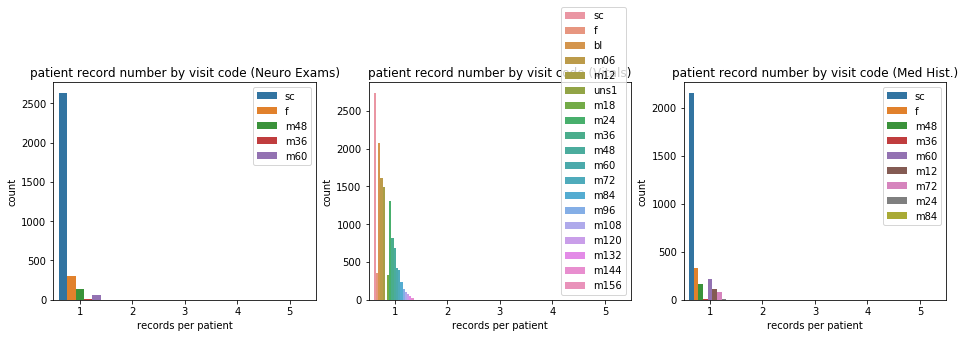

In [36]:
all_dfs = [nex_df, vitals_df, med_df]
df_names = ["Neuro Exams","Vitals","Med Hist."]
grp = "VISCODE2"
bins = np.arange(1,7,1)
nbins = bins.shape[0]-1
plt.figure(figsize=(16,4))
for i,df in enumerate(all_dfs):
    
    # create subplot for histogram of each df
    by_viscode = df.groupby(grp)
    records_per_viscode = by_viscode.apply(patient_num_records)
    
    # get viscodes from df
    viscodes = df[grp].dropna().unique()
    nv = viscodes.shape[0]
    vc = np.tile(viscodes,nbins)
    tmp_counts = np.zeros(viscodes.shape[0]*nbins)
    tmp_n = np.tile(np.arange(1,nbins+1,1).reshape(-1,1),nv).reshape(-1,nv).flatten()
    tmp_df = pd.DataFrame(data=np.vstack((vc,tmp_n,tmp_counts)).T, columns=[grp,"records","count"])
    
    plt.subplot(1,len(all_dfs),i+1)
    for j,code in enumerate(viscodes):
        
        # count num in each category
        tmp_df.loc[tmp_df[grp]==code,'count'] = np.histogram(records_per_viscode[code].values, bins)[0]
        
    sns.barplot(x="records", y="count", hue=grp, data=tmp_df)    

    plt.xlabel("records per patient")
    plt.ylabel("count")
    plt.title("patient record number by visit code ({})".format(df_names[i]))
    plt.legend()
    

**ADNI MERGE**

In [433]:
merge_dict = pd.read_csv("Study Info/ADNIMERGE_DICT.csv")
merge_df = pd.read_csv("Study Info/ADNIMERGE.csv", low_memory=False)

with pd.option_context('display.max_rows', None):
    md = define_terms(merge_df, merge_dict, table_name="ADNIMERGE")


Name: RID,
Type: -4,
Table: ADNIMERGE,
Desc: Participant roster ID,
Code:-4

Name: PTID,
Type: -4,
Table: ADNIMERGE,
Desc: Original study protocol,
Code:-4

Name: VISCODE,
Type: -4,
Table: ADNIMERGE,
Desc: Visit code,
Code:-4

Name: SITE,
Type: -4,
Table: ADNIMERGE,
Desc: Site,
Code:-4

Name: COLPROT,
Type: -4,
Table: ADNIMERGE,
Desc: Study protocol of data collection,
Code:-4

Name: ORIGPROT,
Type: -4,
Table: ADNIMERGE,
Desc: Original study protocol,
Code:-4

Name: EXAMDATE,
Type: -4,
Table: ADNIMERGE,
Desc: Date,
Code:-4

Name: DX_bl,
Type: -4,
Table: ADNIMERGE,
Desc: Baseline Dx,
Code:-4

Name: AGE,
Type: -4,
Table: ADNIMERGE,
Desc: Age,
Code:-4

Name: PTGENDER,
Type: -4,
Table: ADNIMERGE,
Desc: Sex,
Code:-4

Name: PTEDUCAT,
Type: -4,
Table: ADNIMERGE,
Desc: Education,
Code:-4

Name: PTETHCAT,
Type: -4,
Table: ADNIMERGE,
Desc: Ethnicity,
Code:-4

Name: PTRACCAT,
Type: -4,
Table: ADNIMERGE,
Desc: Race,
Code:-4

Name: PTMARRY,
Type: -4,
Table: ADNIMERGE,
Desc: Marital,
Code:-4

Name: 


Name: PIB_bl,
Type: -4,
Table: ADNIMERGE,
Desc: Average PIB SUVR of frontal cortex, anterior cingulate, precuneus cortex, and parietal cortex,
Code:-4

Name: AV45_bl,
Type: -4,
Table: ADNIMERGE,
Desc: Reference region - florbetapir mean of whole cerebellum.  Regions defined by Freesurfer; see Jagust lab PDF on LONI for details,
Code:-4

Name: Years_bl,
Type: -4,
Table: ADNIMERGE,
Desc: nan,
Code:-4

Name: Month_bl,
Type: -4,
Table: ADNIMERGE,
Desc: nan,
Code:-4

Name: Month,
Type: -4,
Table: ADNIMERGE,
Desc: Months since baseline,
Code:-4

Name: M,
Type: -4,
Table: ADNIMERGE,
Desc: Month since baseline,
Code:-4

Name: nan,
Type: nan,
Table: nan,
Desc: nan,
Code:nan

